In [9]:
import pandas as pd
import pickle
from src.prompt import *
import pickle
import ast
import numpy as np
from collections import defaultdict
import re
from typing import List, Dict, Optional

In [ ]:
qa_df = pd.read_csv("/home/yl3427/cylab/SOAP_MA/MA_results/diag.csv")
# for i, row in qa_df.iterrows():
#     print(row['question'])
qa_df[]

,File ID,Assessment,Summary,Subjective,Objective,cleaned_expanded_Summary,terms,combined_summary,pred_sepsis,reasoning_sepsis,pred_acute kidney injury,reasoning_acute kidney injury,pred_pancreatitis,reasoning_pancreatitis,pred_gastrointestinal bleed,reasoning_gastrointestinal bleed
0,101616.txt,67 y/o m cad s/[**initials (namepattern4) **] ...,lower gi bleed; hypotension; cad,colonoscopy - at [**2171-1-25**] 12:31 pm\n- c...,last dose of antibiotics:\ninfusions:\nother i...,lower gastrointestinal bleed; hypotension; cor...,"['lower gastrointestinal bleed', 'hypotension'...",lower gi bleed; hypotension; cadlower gastroin...,No,"To determine if the patient has sepsis, we nee...",No,To determine if the patient has acute kidney i...,No,"To determine if the patient has pancreatitis, ...",Yes,To determine if the patient has a gastrointest...
1,102486.txt,81f with h/o chronic eosinophilic lung disease...,pulmonary embolism; fever; hypotension; oligur...,pleuritic right chest pain\n- patient started ...,last dose of antibiotics:\nciprofloxacin - [**...,pulmonary embolism; fever; hypotension; oligur...,"['pulmonary embolism', 'fever', 'hypotension',...",pulmonary embolism; fever; hypotension; oligur...,No,"To determine if the patient has sepsis, we nee...",No,To determine if the patient has acute kidney i...,No,"To determine if the patient has pancreatitis, ...",No,To determine if the patient has a gastrointest...
2,198989.txt,"79 yo f w/ a h/o chf (ef of 20-30%), carotid s...",sepsis; altered/depressed ms\n thought to be [...,- id: rec bedside echo\n- continued fluid bolu...,last dose of antibiotics:\nmetronidazole - [**...,sepsis; altered depressed mental status though...,"['sepsis', 'altered depressed mental status th...",sepsis; altered/depressed ms\n thought to be [...,Yes,"To determine if the patient has sepsis, we nee...",No,To determine if the patient has acute kidney i...,No,"To determine if the patient has pancreatitis, ...",No,To determine if the patient has a gastrointest...
3,100326.txt,[**age over 90 382**]f presents with history o...,"shock- likely hypovolemic from gi bleed, but m...",multi lumen - start [**2159-8-12**] 01:36 pm\n...,last dose of antibiotics:\nmetronidazole - [**...,shock likely hypovolemic from gastrointestinal...,['shock likely hypovolemic from gastrointestin...,"shock- likely hypovolemic from gi bleed, but m...",Yes,"To determine if the patient has sepsis, we nee...",No,To determine if the patient has acute kidney i...,No,"To determine if the patient has pancreatitis, ...",No,To determine if the patient has a gastrointest...
4,109934.txt,"gastrointestinal bleed, lower (hematochezia, b...",gi bleed; anemia,150 cc blood in stool over night. transfused 3...,last dose of antibiotics:\ninfusions:\nother i...,gastrointestinal bleed; anemia,"['gastrointestinal bleed', 'anemia']",gi bleed; anemiagastrointestinal bleed; anemia...,No,"To determine if the patient has sepsis, we nee...",No,To determine if the patient has acute kidney i...,No,To determine whether the patient has pancreati...,NaN,NaN


In [11]:
mi = ["myocardial infarction", "elevation mi", " NSTEMI", " stemi"]
# 	STEMI vs NSTEMI 감별
#   Type 1 MI vs Type 2 MI 감별

chf = ["congestive heart failure", " chf", "HFrEF", "HFpEF"]
# HFrEF(좌심실 수축기능 저하) vs HFpEF(정상좌심실수축기능/이완기부전)
# Acute decompensated HF vs Chronic stable HF

pulmonary_embolism = ["pulmonary embolism"] # good
# Massive vs Submassive vs Low-risk PE

pulmonary_hypertension = ["pulmonary hypertension", "pulmonary htn"]

sepsis = ["sepsis", "septic shock"] # -> urosepsis인가 아닌가
urosepsis = ["urosepsis"]

meningitis = ["meningitis"]

aki = ["acute kidney injury", " aki", "acute renal failure", " arf"] # -> Acute tubular necrosis (ATN)인가 아닌가
atn = ["acute tubular necrosis", " atn"]


pancreatitis = ["pancreatitis"] # good
gi_bleed = ["gastrointestinal bleed", "gi bleed"] # good
hepatitis = ["hepatitis", " hep"] # 간염

cholangitis = ["cholangitis"]
asp_pneumonia = ["aspiration pneumonia"]

prob_dict = {'myocardial infarction': mi, 
                'congestive heart failure': chf, 
                'pulmonary embolism': pulmonary_embolism, 
                'pulmonary hypertension': pulmonary_hypertension, 
                'sepsis': sepsis, 
                'urosepsis': urosepsis, 
                'meningitis': meningitis, 
                'acute kidney injury': aki, 
                'acute tubular necrosis': atn, 
                'pancreatitis': pancreatitis, 
                'gastrointestinal bleed': gi_bleed, 
                'hepatitis': hepatitis, 
                'cholangitis': cholangitis, 
                'aspiration pneumonia': asp_pneumonia}

In [12]:
import pandas as pd
from typing import List
from sklearn.metrics import precision_recall_fscore_support

def evaluate_problem(df: pd.DataFrame, prob_mentions: List[str]):
    # Convert mention terms to lowercase
    problem_terms = [term.lower() for term in prob_mentions]
    primary_term = problem_terms[0]

    # Construct a regex pattern by joining the mention terms
    pattern = '|'.join(problem_terms)

    # Combine summary columns into a single string (lowercased)
    df['combined_summary'] = (
        df['Summary']
        + df['cleaned_expanded_Summary']
        + df['terms']
    ).str.lower()

    # True label: does 'combined_summary' contain any of the mention terms?
    label = df['combined_summary'].str.contains(pattern, na=False, regex=True)

    # Predictions
    single_pred = df[f"is_{primary_term.replace(' ', '_')}_pred_single"]
    multi_pred  = df[f"is_{primary_term.replace(' ', '_')}_pred_multi"]

    # Calculate metrics for single_pred
    precision_single, recall_single, f1_single, _ = precision_recall_fscore_support(
        label, single_pred, pos_label=True, average='binary'
    )

    # Calculate metrics for multi_pred
    precision_multi, recall_multi, f1_multi, _ = precision_recall_fscore_support(
        label, multi_pred, pos_label=True, average='binary'
    )


    # Define column sets for cleaner DataFrame slicing

    # Read full DF that has the 'Assessment' column
    full_df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023.csv')[['File ID', 'Assessment']]
    df = df.merge(full_df, on='File ID', how='left')

    common_cols  = ['File ID', 'Subjective', 'Objective', 'Summary', 'cleaned_expanded_Summary', 'terms', 'Assessment']
    single_cols  = [f"is_{primary_term.replace(' ', '_')}_pred_single", 
                    f"is_{primary_term.replace(' ', '_')}_reasoning_single"]
    multi_cols   = [f"is_{primary_term.replace(' ', '_')}_pred_multi",  
                    f"is_{primary_term.replace(' ', '_')}_reasoning_multi"]

    # Identify false positives/negatives for single_pred
    false_positives_single = df.loc[(label == False) & (single_pred == True),  common_cols + single_cols]
    false_negatives_single = df.loc[(label == True)  & (single_pred == False), common_cols + single_cols]

    # Identify false positives/negatives for multi_pred
    false_positives_multi = df.loc[(label == False) & (multi_pred == True),  common_cols + multi_cols]
    false_negatives_multi = df.loc[(label == True)  & (multi_pred == False), common_cols + multi_cols]

    # **NEW**: Identify rows where single and multi predictions differ
    mismatched_predictions = df.loc[single_pred != multi_pred, common_cols + single_cols + multi_cols]
    mismatched_false_negatives = mismatched_predictions.loc[label == True]

    # Print out the metrics
    print("=== Single Prediction Metrics ===")
    print(f"Precision: {precision_single:.4f}")
    print(f"Recall:    {recall_single:.4f}")
    print(f"F1 Score:  {f1_single:.4f}\n")

    print("=== Multi Prediction Metrics ===")
    print(f"Precision: {precision_multi:.4f}")
    print(f"Recall:    {recall_multi:.4f}")
    print(f"F1 Score:  {f1_multi:.4f}\n")

    # Print counts of mistakes
    print("=== Single Prediction Errors ===")
    print(f"False Positives (Single): {len(false_positives_single)}")
    print(f"False Negatives (Single): {len(false_negatives_single)}\n")

    print("=== Multi Prediction Errors ===")
    print(f"False Positives (Multi): {len(false_positives_multi)}")
    print(f"False Negatives (Multi): {len(false_negatives_multi)}\n")

    # **NEW**: Print mismatched prediction count
    print("=== Mismatched Single vs Multi Predictions ===")
    print(f"Rows with different predictions: {len(mismatched_predictions)}")
    print(f"False Negatives among mismatched predictions: {len(mismatched_false_negatives)}")

    # Optionally return relevant DataFrames for further use
    return {
        'single': {
            'false_positives': false_positives_single,
            'false_negatives': false_negatives_single
        },
        'multi': {
            'false_positives': false_positives_multi,
            'false_negatives': false_negatives_multi
        },
        'mismatched_predictions': mismatched_predictions,
        'mismatched_false_negatives': mismatched_false_negatives
    }

In [13]:
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/single_result_full.csv')
error_df_dict = {}
for _, value in prob_dict.items():
    false_rows = evaluate_problem(df, value)
    false_rows['single']['false_positives'].to_csv(f'/home/yl3427/cylab/SOAP_MA/error_analysis/{_}_false_positives_single.csv')
    false_rows['single']['false_negatives'].to_csv(f'/home/yl3427/cylab/SOAP_MA/error_analysis/{_}_false_negatives_single.csv')
    false_rows['multi']['false_positives'].to_csv(f'/home/yl3427/cylab/SOAP_MA/error_analysis/{_}_false_positives_multi.csv')
    false_rows['multi']['false_negatives'].to_csv(f'/home/yl3427/cylab/SOAP_MA/error_analysis/{_}_false_negatives_multi.csv')
    false_rows['mismatched_predictions'].to_csv(f'/home/yl3427/cylab/SOAP_MA/error_analysis/{_}_mismatched_predictions.csv')
    false_rows['mismatched_false_negatives'].to_csv(f'/home/yl3427/cylab/SOAP_MA/error_analysis/{_}_mismatched_false_negatives.csv')
    error_df_dict[_] = false_rows

=== Single Prediction Metrics ===
Precision: 0.3750
Recall:    0.6000
F1 Score:  0.4615

=== Multi Prediction Metrics ===
Precision: 0.5208
Recall:    0.5000
F1 Score:  0.5102

=== Single Prediction Errors ===
False Positives (Single): 50
False Negatives (Single): 20

=== Multi Prediction Errors ===
False Positives (Multi): 23
False Negatives (Multi): 25

=== Mismatched Single vs Multi Predictions ===
Rows with different predictions: 44
False Negatives among mismatched predictions: 7
=== Single Prediction Metrics ===
Precision: 0.3413
Recall:    0.4674
F1 Score:  0.3945

=== Multi Prediction Metrics ===
Precision: 0.3929
Recall:    0.3587
F1 Score:  0.3750

=== Single Prediction Errors ===
False Positives (Single): 83
False Negatives (Single): 49

=== Multi Prediction Errors ===
False Positives (Multi): 51
False Negatives (Multi): 59

=== Mismatched Single vs Multi Predictions ===
Rows with different predictions: 60
False Negatives among mismatched predictions: 16
=== Single Prediction

In [14]:
false_rows['single']['false_positives']

,File ID,Subjective,Objective,Summary,cleaned_expanded_Summary,terms,Assessment,is_aspiration_pneumonia_pred_single,is_aspiration_pneumonia_reasoning_single
2,198989.txt,- id: rec bedside echo\n- continued fluid bolu...,last dose of antibiotics:\nmetronidazole - [**...,sepsis; altered/depressed ms\n thought to be [...,sepsis; altered depressed mental status though...,"['sepsis', 'altered depressed mental status th...","79 yo F w/ a h/o CHF (EF of 20-30%), carotid s...",True,The patient's presentation includes a stable l...
10,189311.txt,"69 f w/ mmp including copd, diastolic chf, dm2...",last dose of antibiotics:\ncefipime - [**2139-...,altered mental status; likely urosepsis.; acut...,altered mental status; likely urinary tract in...,"['altered mental status', 'likely urinary trac...","69 F w/ MMP including copd, diastolic chf, dm2...",True,The patient has a history of prolonged hospita...
11,191238.txt,nasal swab - at [**2103-5-11**] 04:11 pm\nekg ...,last dose of antibiotics:\ninfusions:\nother i...,respiratory failure-hypoxia and hypercarbia; a...,respiratory failure hypoxia and hypercarbia; a...,['respiratory failure hypoxia and hypercarbia'...,This is a 67 yom with hx of CAD s/p CABG x 4 i...,True,The patient presents with decreased breath sou...
13,109249.txt,hypoxic respiratory failure\nthoracentesis - a...,last dose of antibiotics:\ncefipime - [**2119-...,ntubation/respiratory failure; acute etoh panc...,intubation respiratory failure; acute ethyl al...,"['intubation respiratory failure', 'acute ethy...","PNEUMONIA, ASPIRATION\n ALCOHOL WITHDRAWAL (IN...",True,The patient presents with hypoxic respiratory ...
16,193820.txt,overnight hypotensive to map 47 from 72 about ...,last dose of antibiotics:\nlevofloxacin - [**2...,nstemi; newly worsened mr; hypotension: acutel...,non st elevation myocardial infarction; newly ...,"['non st elevation myocardial infarction', 'ne...","MYOCARDIAL INFARCTION, ACUTE (AMI, STEMI, NSTE...",True,"The patient's presentation with fever, hypoten..."
...,...,...,...,...,...,...,...,...,...
406,160505.txt,chief complaint: 24 hour events: vanc trough 2...,last dose of antibiotics: vancomycin - 05:00 ...,respiratory failure; hypotensive: ddx sepsis v...,respiratory failure; hypotensive differential ...,"['respiratory failure', 'hypotensive different...","88 y/o F with PMHx of CAD, DM, Atrial Fib, Alz...",True,"The patient is sedated and has been intubated,..."
408,162330.txt,ccu intern progress note: 24 hour events: - co...,last dose of antibiotics: vancomycin - 09:00 ...,ventricular tachycardia: likely result of scar...,ventricular tachycardia likely result of scarr...,['ventricular tachycardia likely result of sca...,"39M w/ PMhx of Ebstein's anomaly, s/p tricuspi...",True,The patient is intubated and has been on venti...
409,163063.txt,chief complaint: respiratory failure i saw and...,last dose of antibiotics: bactrim (smx/tmp) - ...,respiratory failure; idiopathic pneumonitis; l...,respiratory failure; idiopathic pneumonitis; l...,"['respiratory failure', 'idiopathic pneumoniti...",68 yo male with renal cell CA and lymphoma now...,True,The patient's presentation with respiratory fa...
432,177953.txt,title: chief complaint: shortness of breath 24...,last dose of antibiotics: piperacillin - 04:0...,sepsis: source likely pneumonia and mrsa bacte...,sepsis source likely pneumonia and methicillin...,['sepsis source likely pneumonia and methicill...,"81 year old man with a history of CHF, Afib, C...",True,"The patient presents with shortness of breath,..."


In [15]:
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/single_result.csv')
for name, lst in prob_dict.items():
    print(name)
    df['combined_summary'] = df['Summary'] + df['cleaned_expanded_Summary'] + df['terms']
    df[name] = df['combined_summary'].str.contains('|'.join(lst), regex=True, na=False)
    for i, row in df.iterrows():
        multi_col = f"is_{name.lower().replace(' ', '_')}_pred_multi"
        single_col = f"is_{name.lower().replace(' ', '_')}_pred_single"
        print(row[name], row[single_col], row[multi_col])
    print(df[name].sum(), df[single_col].sum(), df[multi_col].sum())

myocardial infarction
False False False
False False False
False True False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
0 1 0
congestive heart failure
False False False
True False False
False True True
False False False
False False False
False False False
False False False
False False False
False False False
False False False
1 1 1
pulmonary embolism
False False False
True True False
False False False
True False False
False False False
False False False
True True True
False False False
False False False
False False False
3 2 1
pulmonary hypertension
False False False
False False False
False True True
False False False
False False False
False False False
False False False
False False False
False False False
False False False
0 1 1
sepsis
False False False
False False False
True False True
False True True
False True True
True True True
False False False
False False False
False True False
False False False
2 

In [16]:
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023.csv')
df.columns

Index(['File ID', 'Assessment', 'Summary', 'Subjective', 'Objective',
       'Summary_lemma', 'Summary_expanded', 'Summary_umls',
       'Summary_lemma_umls', 'Summary_expanded_umls',
       'cleaned_expanded_Summary', 'terms'],
      dtype='object')

In [17]:
import pandas as pd
ids = set()
for name, lst in prob_dict.items():
    problem_terms = lst
    problem_terms = [term.lower() for term in problem_terms]

    df = pd.read_csv(
        '/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023.csv',
        usecols=['File ID', 'Subjective', 'Objective', 'Summary', 'cleaned_expanded_Summary', 'terms']
    )

    df = df.fillna('').apply(lambda x: x.str.lower())

    df['combined_summary'] = df['Summary'] + df['cleaned_expanded_Summary'] + df['terms']

    # Use the first term as the primary term to check in the combined summary.
    primary_term = problem_terms[0]

    # Build a regex pattern that matches any of the problem terms.
    pattern = '|'.join(problem_terms)

    mask = (
        df['combined_summary'].str.contains(pattern, na=False, regex=True) &
        ~df['Subjective'].str.contains(pattern, na=False, regex=True) &
        ~df['Objective'].str.contains(pattern, na=False, regex=True)
    )

    filtered_df = df[mask]
    print(name, len(filtered_df))

    ids.update(filtered_df['File ID'])

myocardial infarction 48
congestive heart failure 92
pulmonary embolism 29
pulmonary hypertension 7
sepsis 110
urosepsis 9
meningitis 6
acute kidney injury 129
acute tubular necrosis 9
pancreatitis 15
gastrointestinal bleed 67
hepatitis 30
cholangitis 9
aspiration pneumonia 15


In [18]:
len(ids)

445

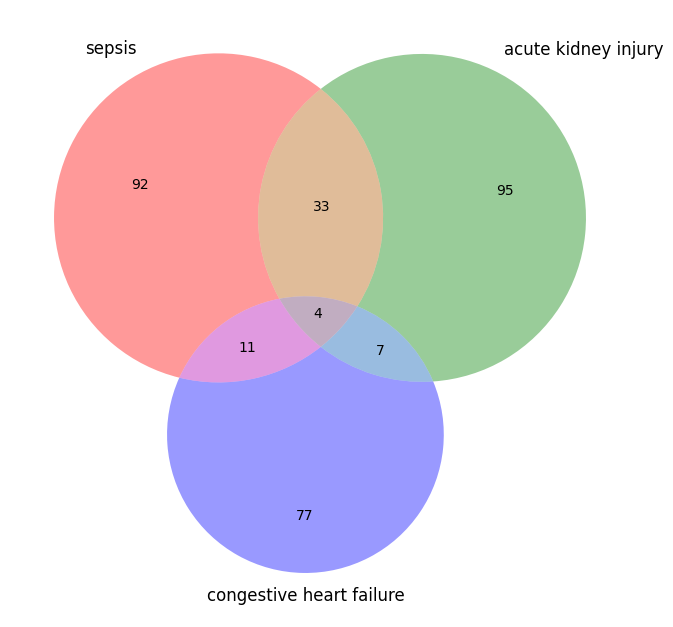

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# CSV 파일 읽기 (이미 전처리된 데이터셋)
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023.csv', usecols=['Subjective', 'Objective', 'Summary', 'cleaned_expanded_Summary', 'terms'])
df = df.fillna('').apply(lambda x: x.str.lower())
df['combined_summary'] = df['Summary'] + df['cleaned_expanded_Summary'] + df['terms']

key1 = 'sepsis'
key2 = 'acute kidney injury'
key3 = 'congestive heart failure'
# key4 = 'gi_bleed'
# 각 질병에 대해 인스턴스(행) 인덱스 집합 생성
set1 = set(df[df['combined_summary'].str.contains('|'.join(prob_dict[key1]).lower(), regex=True, na=False)].index)
set2 = set(df[df['combined_summary'].str.contains('|'.join(prob_dict[key2]).lower(), regex=True, na=False)].index)
set3 = set(df[df['combined_summary'].str.contains('|'.join(prob_dict[key3]).lower(), regex=True, na=False)].index)
# set4 = set(df[df['combined_summary'].str.contains('|'.join(prob_dict[key4]), regex=True, na=False)].index)

plt.figure(figsize=(8, 8))
venn3([set1, set2, set3], (key1, key2, key3))
plt.show()

/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

<Figure size 1000x600 with 0 Axes>

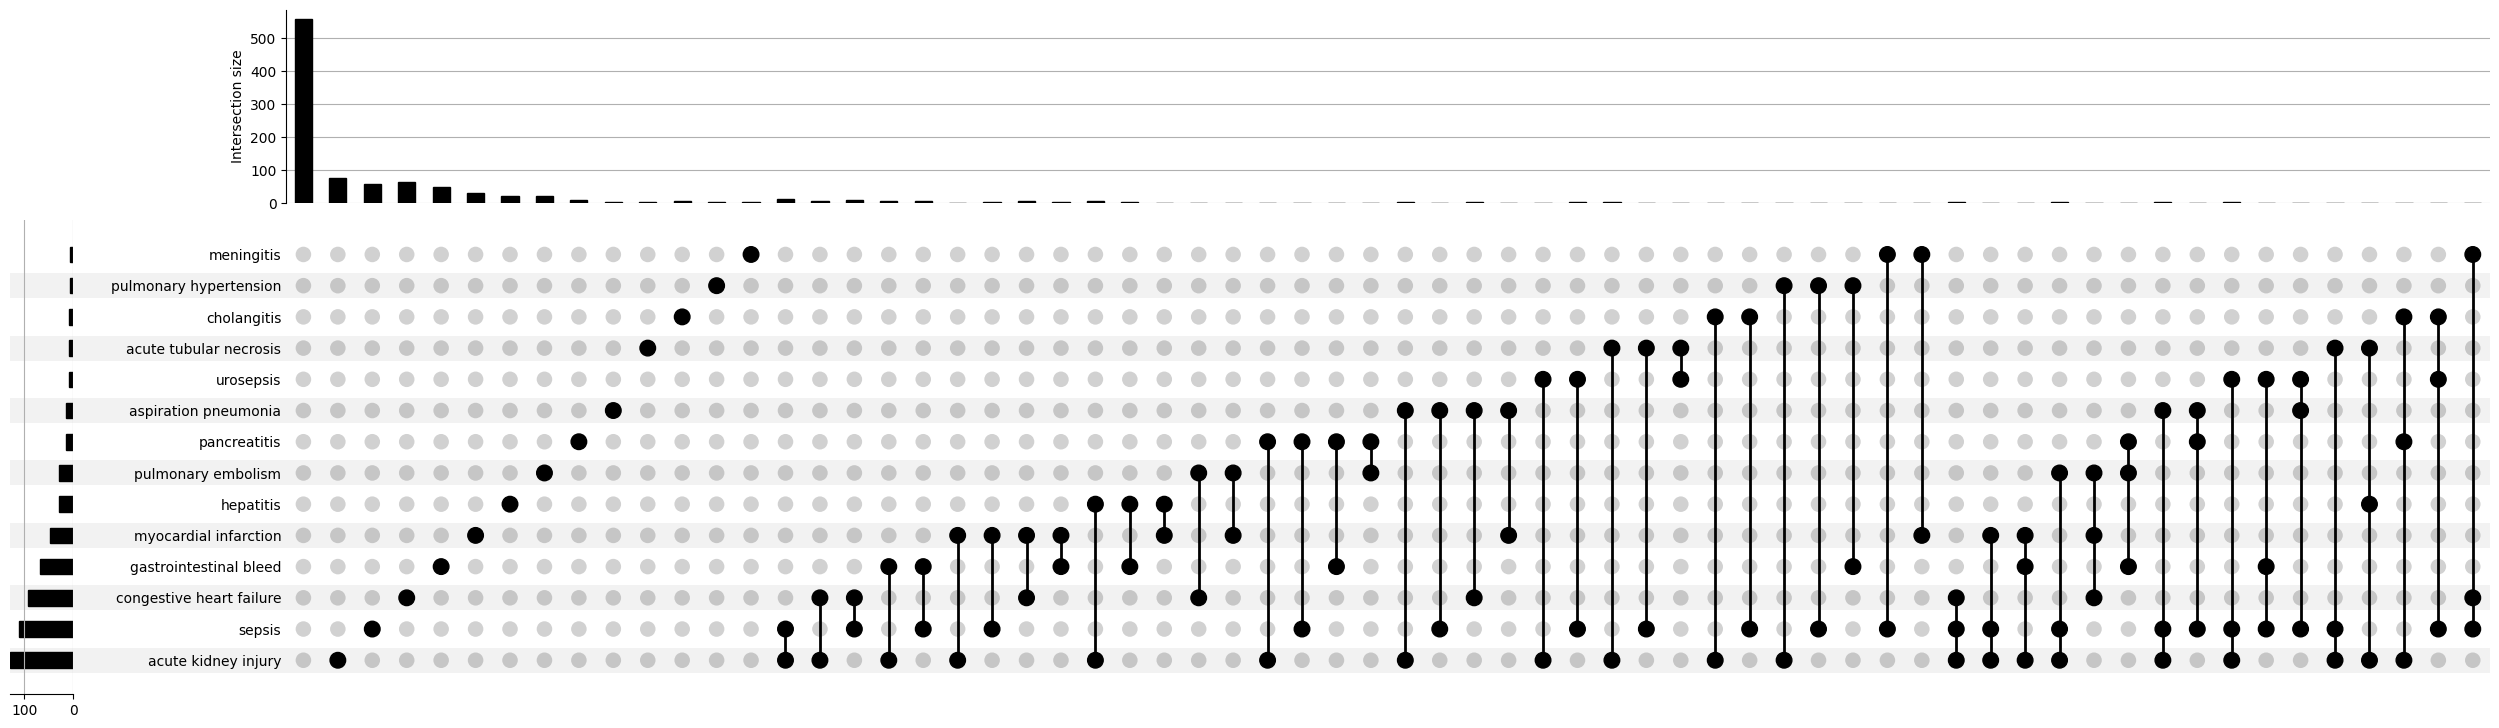

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import from_indicators, plot

for name, lst in prob_dict.items():
    # df[name] = df['combined_summary'].str.contains('|'.join(lst), regex=True, na=False)
    lst = [term.lower() for term in lst]
    pattern = '|'.join(lst)
    con = ( df['combined_summary'].str.contains(pattern, na=False, regex=True) &
        ~df['Subjective'].str.contains(pattern, na=False, regex=True) &
        ~df['Objective'].str.contains(pattern, na=False, regex=True))
    df[name] = con

# UpSet Plot을 위한 데이터셋 생성
binary_df = df[list(prob_dict.keys())]
upset_data = from_indicators(binary_df.columns.tolist(), binary_df)

plt.figure(figsize=(10, 6))
plot(upset_data) 
plt.show()

In [21]:
df = binary_df
print(df[df[list(prob_dict.keys())].sum(axis=1) > 0].shape)
print(df[df[list(prob_dict.keys())].sum(axis=1) > 1].shape)
print(df[df[list(prob_dict.keys())].sum(axis=1) > 2].shape)

(445, 14)
(107, 14)
(23, 14)


In [ ]:
filtered_df.loc[675].Objective

In [ ]:
prob = "renal failure"
prob2 = "ARF"
prob3 = "CRF"
n=0
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023.csv')[['Assessment', 'Summary', 'Subjective', 'Objective', 'cleaned_expanded_Summary', 'terms']]
for i, row in df.iterrows():
    sub = row['Subjective']
    obj = row['Objective']
    sum = row['Summary'] + row['cleaned_expanded_Summary'] + row['terms']
    if type(sum) != str or type(sub) != str or type(obj) != str:
        continue
    sub = sub.lower()
    obj = obj.lower()
    sum = sum.lower()
    if (prob in sum) and (prob not in sub) and (prob not in obj) and (prob2 not in sub) and (prob2 not in obj) and (prob3 not in sub) and (prob3 not in obj):
        n+=1
        print(i, row['Summary'])
n

In [ ]:
term_set = set()
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023_interest.csv')[['Subjective', 'Objective', 'Assessment', 'terms']]
df['terms'] = df['terms'].apply(lambda x: ast.literal_eval(x))
for i in range(len(df)):
    term_set.update(df['terms'][i])

In [ ]:
sorted_term_set = sorted(list(term_set))
sorted_term_set = [x for x in sorted_term_set if x != '']
", ".join(sorted_term_set)

In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term_idx in range(0, len(terms_interest)-1, 2):
    problem_1 = terms_interest[term_idx]
    problem_2 = terms_interest[term_idx+1]
    df = pd.read_csv(f"/home/yl3427/cylab/SOAP_MA/data/0212_results_multi_{problem_1}_{problem_2}.csv")
    print(len(df))

In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term in terms_interest:
    df = pd.read_csv(f"/home/yl3427/cylab/SOAP_MA/data/0212_results_single_{term}.csv")[["terms", f"{term}", f"is_{term.replace(' ', '_')}_baseline", f"is_{term.replace(' ', '_')}_ltm"]]
    print(len(df))
    print("-------------------")

In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term in terms_interest:
    df = pd.read_csv(f"/home/yl3427/cylab/SOAP_MA/data/0212_results_single_{term}.csv")[["terms", f"{term}", f"is_{term.replace(' ', '_')}_baseline", f"is_{term.replace(' ', '_')}_ltm"]]
    
    results = evaluate_results(df, term)
    print(f"Baseline {term} F1: {results['baseline']['f1_score']:.3f}")
    print(f"LTM {term} F1: {results['ltm']['f1_score']:.3f}")
    print()
    print(f"Baseline {term} Precision: {results['baseline']['precision']:.3f}")
    print(f"LTM {term} Precision: {results['ltm']['precision']:.3f}")
    print()
    print(f"Baseline {term} Recall: {results['baseline']['recall']:.3f}")
    print(f"LTM {term} Recall: {results['ltm']['recall']:.3f}")
    print("====================================")

In [ ]:
terms_interest = [
    'hypertension', 'acute renal failure', 'atrial fibrillation', 'anemia',
    'coronary artery disease', 'hypotension', 'altered mental status',
    'respiratory failure', 'diabetes mellitus', 'leukocytosis'
]

for term in terms_interest:
    df = pd.read_csv(
        f"/home/yl3427/cylab/SOAP_MA/data/0212_results_single_{term}.csv"
    )[["terms", f"{term}", 
       f"is_{term.replace(' ', '_')}_baseline", 
       f"is_{term.replace(' ', '_')}_ltm"]]
    
    results = evaluate_results(df, term)
    
    # 표 헤더 출력
    print(f"Results for: {term}")
    print("=" * 48)
    print(f"{'':<12}{'Precision':>12}{'Recall':>12}{'F1':>12}")
    print("-" * 48)
    
    # Baseline 결과 출력
    print(f"{'Baseline':<12}"
          f"{results['baseline']['precision']:>12.3f}"
          f"{results['baseline']['recall']:>12.3f}"
          f"{results['baseline']['f1_score']:>12.3f}")
    
    # LTM 결과 출력
    print(f"{'LTM':<12}"
          f"{results['ltm']['precision']:>12.3f}"
          f"{results['ltm']['recall']:>12.3f}"
          f"{results['ltm']['f1_score']:>12.3f}")
    
    print("\n")


In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term_idx in range(0, len(terms_interest)-1, 2):
    problem_1 = terms_interest[term_idx]
    problem_2 = terms_interest[term_idx+1]
    print(f"<Given LTM for {problem_1} and {problem_2}>")
    print()
    df = pd.read_csv(f"/home/yl3427/cylab/SOAP_MA/data/0212_results_multi_{problem_1}_{problem_2}.csv")
    results = evaluate_results(df, problem_1)

    # 표 헤더 출력
    print(f"Results for: {problem_1}")
    print("=" * 48)
    print(f"{'':<12}{'Precision':>12}{'Recall':>12}{'F1':>12}")
    print("-" * 48)
    
    # Baseline 결과 출력
    print(f"{'Baseline':<12}"
          f"{results['baseline']['precision']:>12.3f}"
          f"{results['baseline']['recall']:>12.3f}"
          f"{results['baseline']['f1_score']:>12.3f}")
    
    # LTM 결과 출력
    print(f"{'LTM':<12}"
          f"{results['ltm']['precision']:>12.3f}"
          f"{results['ltm']['recall']:>12.3f}"
          f"{results['ltm']['f1_score']:>12.3f}")
    
    print("\n")


    results = evaluate_results(df, problem_2)
    # 표 헤더 출력
    print(f"Results for: {problem_2}")
    print("=" * 48)
    print(f"{'':<12}{'Precision':>12}{'Recall':>12}{'F1':>12}")
    print("-" * 48)
    
    # Baseline 결과 출력
    print(f"{'Baseline':<12}"
          f"{results['baseline']['precision']:>12.3f}"
          f"{results['baseline']['recall']:>12.3f}"
          f"{results['baseline']['f1_score']:>12.3f}")
    
    # LTM 결과 출력
    print(f"{'LTM':<12}"
          f"{results['ltm']['precision']:>12.3f}"
          f"{results['ltm']['recall']:>12.3f}"
          f"{results['ltm']['f1_score']:>12.3f}")
    
    print("\n")

In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term in terms_interest:
    print(term)
    df = pd.read_csv(f"/home/yl3427/cylab/SOAP_MA/data/0212_results_{term}.csv")
    for i, row in df.iterrows():
        # print(row["terms"], row["anemia"], row["is_anemia_baseline"], row["is_anemia_ltm"])
        # print(row["Subjective"], row["Objective"], row["Assessment"])
        # print("-------------------")
        pass
    print(df["terms"].values)
    print("-------------------")

In [ ]:
def safe_eval(cell):
    if pd.isna(cell) or not isinstance(cell, str):
        print(cell)
        return cell
    return ast.literal_eval(cell)

In [ ]:
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023.csv')

In [ ]:
df.dropna(inplace=True, ignore_index=True)

In [ ]:
df['terms'] = df['terms'].apply(safe_eval)

In [ ]:
df['terms']

In [ ]:
for i, row in df.iterrows():
    if type(row['terms']) != list:
        print(f"{i} is not a list: {row}")


In [ ]:
for i, row in df.iterrows():
    if "rectal prolapse" in str(row['terms']):
        txt = row['Subjective'] + row['Objective']
        txt = txt.lower()
        if ("rectal prolapse" not in txt):
            print(row['terms'])
            print(txt)
            print("----------")

In [ ]:
for i, row in df.iterrows():
    if "sepsis" in str(row['terms']):
        txt = row['Subjective'] + row['Objective']
        txt = txt.lower()
        if ("sepsis" not in txt) and ("septic" not in txt):
            print(row['terms'])
            print(txt)
            print("----------")

In [ ]:
term_set = set()
for terms in df['terms']:
    term_set.update(terms)
sorted(term_set)

In [ ]:
term_counts = defaultdict(int)
for terms in df['terms']:
    for item in terms:
        term_counts[item] += 1

In [ ]:
sorted(term_counts.items(), key=lambda x: x[1], reverse=True)

In [ ]:
terms_interest = [k for k, v in sorted(term_counts.items(), key=lambda x: x[1], reverse=True)[:10]]

In [ ]:
sorted(term_counts.items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
terms_interest

In [ ]:
for i, row in df.iterrows():
    for term in terms_interest:
        if term == 'diabetes mellitus':
            if ('diabetic' in str(row['terms'])) or ('diabetes' in str(row['terms'])):
                df.at[i, term] = True
            else:
                df.at[i, term] = False
        else:
            if term in str(row['terms']):
                df.at[i, term] = True
            else:
                df.at[i, term] = False

In [ ]:
df_interest = df[df[terms_interest].any(axis=1)].reset_index(drop=True)
df_interest

In [ ]:
df_interest.to_csv('/home/yl3427/cylab/SOAP_MA/data/mergedBioNLP2023_interest.csv', index=False)

In [ ]:
terms_interest

In [ ]:
split = {key: [] for key in terms_interest}
for term in terms_interest:
    for i, row in df_interest.iterrows():
        if row[term]:
            split[term].append(row['File ID'])

In [ ]:
for k, v in split.items():
    print(f"{k}: {len(v)}")

# save split into pickle
with open('/home/yl3427/cylab/SOAP_MA/data/split.pkl', 'wb') as f:
    pickle.dump(split, f)

In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term in terms_interest:
    train_ids = split[term][:10]
    train_df = df_interest[df_interest['File ID'].isin(train_ids)]
    print(train_df[terms_interest])


In [ ]:
from pydantic import BaseModel, Field
from typing import List
class ResponseDiagnosisWithReasoning(BaseModel):
    reasoning: str = Field(
        ...,
        description="Step-by-step reasoning that leads to the final diagnosis."
    )
    diagnosis: bool = Field(
        ...,
        description="Binary diagnosis: True if patient has the disease, False otherwise."
    )
ResponseDiagnosisWithReasoning.model_json_schema()

# Load LTM

In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term_idx in range(0, len(terms_interest)-1, 2):
    problem_1 = terms_interest[term_idx]
    problem_2 = terms_interest[term_idx + 1]
    print(problem_1, problem_2)

In [ ]:
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term in terms_interest:
    print(term)
    with open(f"/home/yl3427/cylab/SOAP_MA/ltm_per_disease/0212_memory_{term}.pkl", "rb") as file:
        ltm = pickle.load(file)

    print(f"\t# of items: {len(ltm)}")
    print(f"\tTotal characters: {sum([len(item) for item in ltm])}")
    # print(ltm)
    print("-------------------")

In [ ]:
ltm

In [ ]:
prompt_test_multi_baseline = """
You are provided with only the Subjective (S) and Objective (O) sections of a new patient's SOAP-formatted progress note that may be relevant to one or more of the following diseases:

1. {PROBLEM_1}
2. {PROBLEM_2}

Patient Report:
<Subjective>
{subj}
</Subjective>

<Objective>
{obj}
</Objective>

For each of the diseases, provide a detailed, step-by-step reasoning on how you arrive at a conclusion based on the patient report, and then state a final binary diagnosis ("True" if the patient is diagnosed with the disease, "False" if not).

Format your answer as valid JSON exactly as follows:
{{
    "diagnoses": {{
         "{PROBLEM_1}": {{
              "reasoning": "Your reasoning here...",
              "diagnosis": true_or_false
         }},
         "{PROBLEM_2}": {{
              "reasoning": "Your reasoning here...",
              "diagnosis": true_or_false
         }}
    }}
}}

Ensure that the reasoning comes before the diagnosis for each disease.
"""

In [ ]:
from pydantic import BaseModel, Field, create_model

# Define the DiseaseDiagnosis model first.
class DiseaseDiagnosis(BaseModel):
    reasoning: str = Field(..., description="Step-by-step reasoning that leads to the final diagnosis.")
    diagnosis: bool = Field(..., description="Binary diagnosis: True if the patient has the disease, False otherwise.")

# Assume these values are provided dynamically.
problem_1 = "Hypertension"
problem_2 = "Acute Renal Failure"

DynamicResponseMultiDiagnosis = create_model(
    'DynamicResponseMultiDiagnosis',
    **{
        problem_1: (DiseaseDiagnosis, ...),
        problem_2: (DiseaseDiagnosis, ...),
    }
)

DynamicResponseMultiDiagnosis.model_json_schema()

In [ ]:
DiseaseDiagnosis.model_json_schema()

In [ ]:
ltm_dict = {}
terms_interest = ['hypertension','acute renal failure',
                      'atrial fibrillation','anemia','coronary artery disease',
                      'hypotension', 'altered mental status', 'respiratory failure',
                      'diabetes mellitus', 'leukocytosis']
for term in terms_interest:
    with open(f"/home/yl3427/cylab/SOAP_MA/ltm_per_disease/0211_memory_{term}.pkl", "rb") as file:
        ltm = pickle.load(file)
        ltm_dict[term] = ltm[1]

In [ ]:
for k, v in ltm_dict.items():
    print(f"{k}: {len(v)}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_results(df, term):

    label_col = term
    baseline_col = f"is_{term.replace(' ', '_')}_baseline"
    ltm_col = f"is_{term.replace(' ', '_')}_ltm"
    
    df[label_col] = df[label_col].replace({'True': True, 'False': False})
    df[label_col] = df[label_col].astype(bool)

    df[baseline_col] = df[baseline_col].replace({'True': True, 'False': False})
    df[baseline_col] = df[baseline_col].astype(bool)

    df[ltm_col] = df[ltm_col].replace({'True': True, 'False': False})
    df[ltm_col] = df[ltm_col].astype(bool)

    num_original_rows = len(df)

    filtered_df = df.dropna(subset=[label_col, baseline_col, ltm_col])

    # debug_target_values(filtered_df, label_col, baseline_col, ltm_col)
  
    num_rows_dropped = num_original_rows - len(filtered_df)
    num_rows_evaluated = len(filtered_df)
    print(f"Number of rows dropped: {num_rows_dropped}")
    print(f"Number of rows evaluated: {num_rows_evaluated}")

    y_true = filtered_df[label_col]
    y_pred_baseline = filtered_df[baseline_col]
    y_pred_ltm = filtered_df[ltm_col]

    prec_baseline = precision_score(y_true, y_pred_baseline, zero_division=0)
    rec_baseline  = recall_score(y_true, y_pred_baseline, zero_division=0)
    f1_baseline   = f1_score(y_true, y_pred_baseline, zero_division=0)

    prec_ltm = precision_score(y_true, y_pred_ltm, zero_division=0)
    rec_ltm  = recall_score(y_true, y_pred_ltm, zero_division=0)
    f1_ltm   = f1_score(y_true, y_pred_ltm, zero_division=0)

    return {
        "num_original_rows": num_original_rows,
        "num_rows_dropped": num_rows_dropped,
        "num_rows_evaluated": num_rows_evaluated,
        "baseline": {
            "precision": prec_baseline,
            "recall":    rec_baseline,
            "f1_score":  f1_baseline
        },
        "ltm": {
            "precision": prec_ltm,
            "recall":    rec_ltm,
            "f1_score":  f1_ltm
        }
    }

def debug_target_values(df, label_col, baseline_col, ltm_col):
    print("Unique values in label:", df[label_col].unique())
    print("Unique values in baseline:", df[baseline_col].unique())
    print("Unique values in ltm:", df[ltm_col].unique())

    print("Label dtype:", df[label_col].dtype)
    print("Baseline dtype:", df[baseline_col].dtype)
    print("LTM dtype:", df[ltm_col].dtype)


In [ ]:
terms_lst = [
    "acute renal failure",
    "anemia",
    "atrial fibrillation",
    "coronary artery disease",
    "hypertension",
]

In [ ]:
import tiktoken

In [ ]:
import tiktoken

enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4o")
len(enc.encode("how?"))